In [1]:
from MPyDATA import ScalarField, VectorField, PeriodicBoundaryCondition, Options, Stepper, Solver

In [2]:
import numpy as np

In [3]:
dt, dx, dy = .1, .2, .3
nt, nx, ny = 100, 15, 10

# https://en.wikipedia.org/wiki/Arakawa_grids#Arakawa_C-grid
x, y = np.mgrid[
    dx/2 : nx*dx : dx, 
    dy/2 : ny*dy : dy
]

In [11]:
# vector field (u,v) components

# u - x component of the velocity field
ux, uy = np.mgrid[
    0 : (nx+1)*dx : dx, 
    dy/2 : ny*dy : dy
]

# v - y component of the velocity field
vx, vy = np.mgrid[
    dx/2 : nx*dx : dx,
    0: (ny+1)*dy : dy
]

In [12]:
from matplotlib import pyplot, rcParams
rcParams['figure.figsize'] = [12, 8]

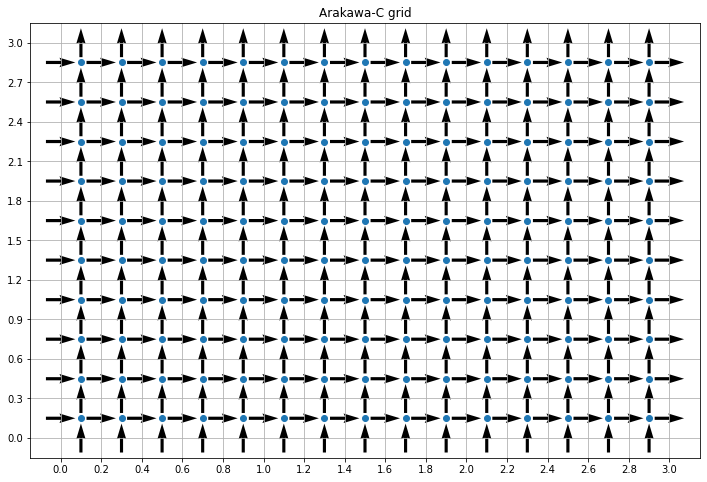

In [13]:
pyplot.quiver(ux, uy, 1, 0, pivot='mid')
pyplot.quiver(vx, vy, 0, 1, pivot='mid')

pyplot.xticks(ux[:,0])
pyplot.yticks(vy[0,:])

pyplot.scatter(x, y)
pyplot.title('Arakawa-C grid')
pyplot.grid()
pyplot.show()

In [14]:
from MPyDATA import ScalarField, VectorField, PeriodicBoundaryCondition, Options, Stepper, Solver

In [15]:
bc = [PeriodicBoundaryCondition(), PeriodicBoundaryCondition()]

In [16]:
options = Options()

In [50]:
data = np.zeros((nx, ny))
data[1,1] = 10

advectee = ScalarField(data, options.n_halo, boundary_conditions=bc)

In [51]:
# https://en.wikipedia.org/wiki/Stream_function

stream function:   
$u=-\partial_y \psi$   
$v=\partial_x \psi$

example flow field:   
$\psi(x,y) = - w_{\text{max}} \frac{X}{\pi} 
  \sin\left(\pi \frac{y}{Y}\right)
  \cos\left(2\pi\frac{x}{X}\right)
$   

In [52]:
class Psi:
    def __init__(self, *, X, Y, w_max):
        self.X = X
        self.Y = Y
        self.w_max = w_max
        
    def __call__(self, x, y):
        return - self.w_max * self.X / np.pi * np.sin(np.pi * y/self.Y) * np.cos(2 * np.pi * x/self.X)

In [53]:
psi = Psi(X=nx*dx, Y=ny*dy, w_max=.6)

In [54]:
print(psi(0,0))

-0.0


In [55]:
print(psi(1,1))

0.24809800293980627


In [56]:
# https://en.wikipedia.org/wiki/Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition

# C_x = u * dt / dx
# C_y = v * dt / dy

u = -(psi(ux, uy+dy/2) - psi(ux, uy-dy/2)) / dy 
v = +(psi(vx+dx/2, vy) - psi(vx-dx/2, vy)) / dx

advector = VectorField([u*dt/dx, v*dt/dy], halo=options.n_halo, boundary_conditions=bc)

In [57]:
def plot(advectee, advector):
    pyplot.scatter(x, y, s=100, c=advectee.get(), marker='s')
    pyplot.quiver(ux, uy, advector.get_component(0), 0, pivot='mid', scale=10)
    pyplot.quiver(vx, vy, 0, advector.get_component(1), pivot='mid', scale=10)
    pyplot.xticks(ux[:,0])
    pyplot.yticks(vy[0,:])
    pyplot.colorbar()
    pyplot.grid()
    pyplot.show()

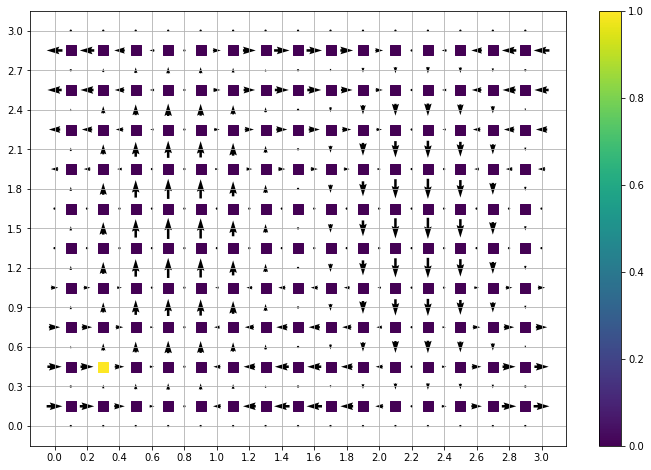

In [58]:
plot(advectee, advector)

In [59]:
stepper = Stepper(options=options, grid=(nx, ny))

In [60]:
solver = Solver(stepper=stepper, advectee=advectee, advector=advector)

In [61]:
solver.advance(20)

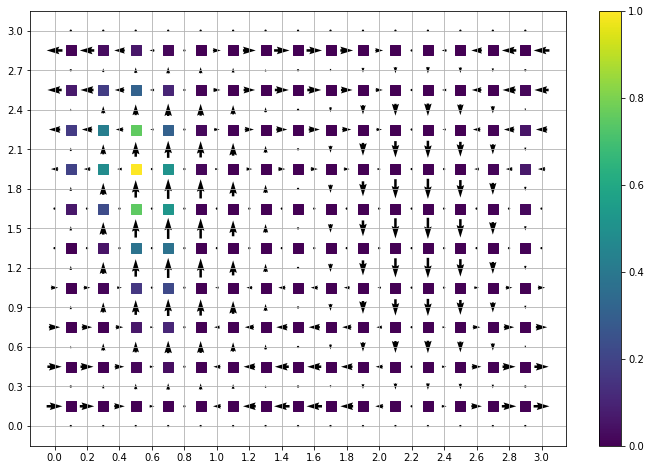

In [62]:
plot(advectee, advector)

In [63]:
# https://en.wikipedia.org/wiki/NetCDF

In [64]:
from scipy.io.netcdf import netcdf_file

In [84]:
with netcdf_file('test.nc', mode='w') as ncdf:
    # global attributes (metadata)
    ncdf.MPyDATA_options = str(options)
    
    # dimensions
    ncdf.createDimension("T", nt)
    ncdf.createDimension("X", nx)
    ncdf.createDimension("Y", ny)
    
    # variables (defined over defined dimensions)
    variables = {}
    variables["T"] = ncdf.createVariable("T", "f", ["T"])
    variables["T"].units = "seconds"
    variables["T"][:] = 0

    variables["X"] = ncdf.createVariable("X", "f", ["X"])
    variables["X"][:] = x[:, 0]
    variables["X"].units = "metres"

    variables["Y"] = ncdf.createVariable("Y", "f", ["Y"])
    variables["Y"][:] = y[0, :]
    variables["Y"].units = "metres"
    
    variables["advectee"] = ncdf.createVariable("advectee", "f", ["T", "X", "Y"])
    
    # attributes (per variable)
    # e.g. units above
    
    # note: initial condition not saved
    for i in range(nt):
        solver.advance(nt=1)
        variables["T"][i] = (i+1) * dt
        variables["advectee"][i, :, :] = solver.curr.get()

In [85]:
! ls -lah test.nc

-rw-r--r-- 1 slayoo slayoo 60K May 25 10:55 test.nc


In [86]:
! file test.nc

test.nc: NetCDF Data Format data


In [89]:
! ncdump -c test.nc

netcdf test {
dimensions:
	T = 100 ;
	X = 15 ;
	Y = 10 ;
variables:
	float advectee(T, X, Y) ;
	float T(T) ;
		T:units = "seconds" ;
	float X(X) ;
		X:units = "metres" ;
	float Y(Y) ;
		Y:units = "metres" ;

// global attributes:
		:MPyDATA_options = "{\'n_iters\': 2, \'infinite_gauge\': False, \'epsilon\': 1e-15, \'divergent_flow\': False, \'flux_corrected_transport\': False, \'third_order_terms\': False, \'non_zero_mu_coeff\': False}" ;
data:

 T = 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 
    1.6, 1.7, 1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3, 
    3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4, 4.1, 4.2, 4.3, 4.4, 4.5, 
    4.6, 4.7, 4.8, 4.9, 5, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6, 
    6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7, 7.1, 7.2, 7.3, 7.4, 7.5, 
    7.6, 7.7, 7.8, 7.9, 8, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9, 
    9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10 ;

 X = 0.1, 0.3, 0.5, 0.7, 0.9, 1.

In [71]:
# https://en.wikipedia.org/wiki/Climate_and_Forecast_Metadata_Conventions

In [90]:
# try opening in Paraview (https://en.wikipedia.org/wiki/ParaView)...